In [88]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('png', 'pdf')
set_matplotlib_formats('svg')

In [89]:
def analyze_encoding(name, results_path):
    df = pd.read_csv(results_path, index_col=[0, 1])
    
    fig, ax = plt.subplots(figsize=(15, 5))
    sns.violinplot(x="subject", y="value", hue="type", data=df.reset_index().melt(id_vars=["subject", "type"], value_vars=["mar_fold_%i" % i for i in range(18)]), ax=ax)
    plt.ylim((40, 260))
    plt.ylabel("average rank")
    
    subj_perf = df.groupby("type").apply(lambda sub_df: sub_df.reset_index(level=0, drop=True).mean(axis=1)).T
    subj_perf.plot.bar(title="Within-subject MAR")
    
    return subj_perf

In [90]:
stats = {}

--------

type,ridge,ridge_permute
subject,,
P01,47.748677,168.166667
M02,65.761905,185.158730
M04,132.388889,193.939153
M07,79.447090,190.261905
M08,115.373016,190.187831
M09,126.859788,187.145503
M14,143.597884,197.523810
M15,91.346561,182.920635


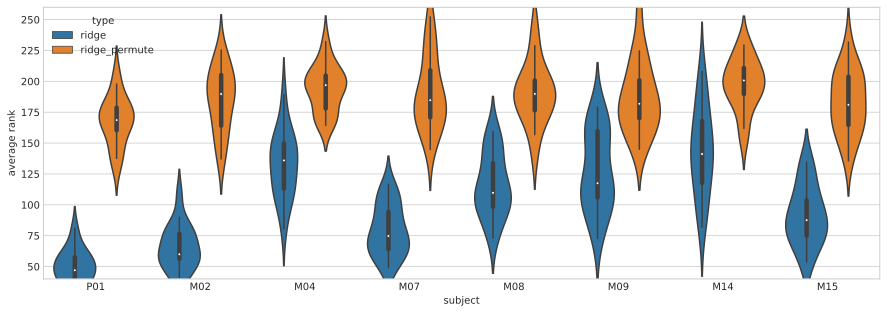

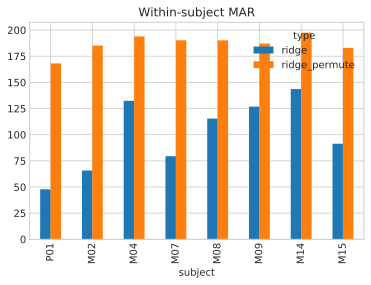

In [91]:
stats["pereira"] = analyze_encoding("pereira", "perf.384sentences.baseline.dim256.csv")
stats["pereira"]

--------

type,ridge,ridge_permute
subject,,
P01,113.751323,198.703704
M02,123.259259,200.132275
M04,153.743386,205.632275
M07,128.767196,200.949735
M08,139.386243,193.568783
M09,166.116402,208.640212
M14,174.132275,197.034392
M15,133.875661,201.082011


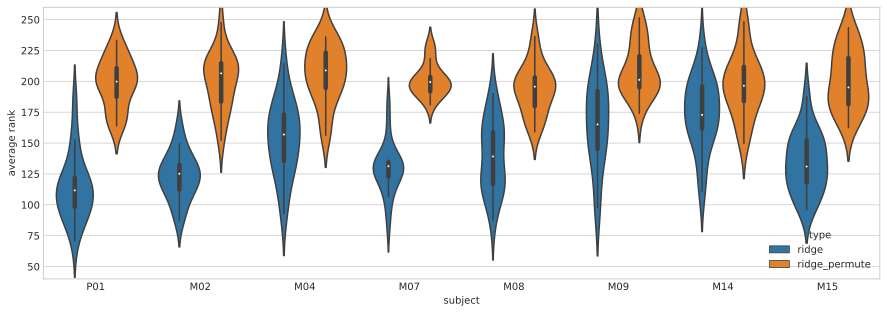

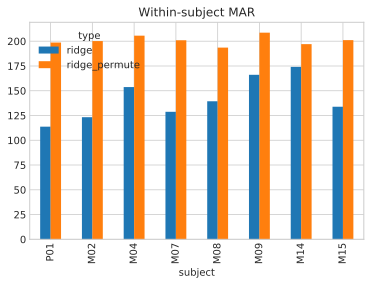

In [92]:
stats["fairseq"] = analyze_encoding("fairseq", "perf.384sentences.fairseq.wmt14.en-fr.fconv.dim256.csv")
stats["fairseq"]

------------

type,ridge,ridge_permute
subject,,
P01,74.126984,187.592593
M02,87.518519,188.600529
M04,132.613757,203.021164
M07,104.724868,194.148148
M08,120.325397,207.000000
M09,147.743386,205.462963
M14,151.791005,202.468254
M15,110.764550,186.931217


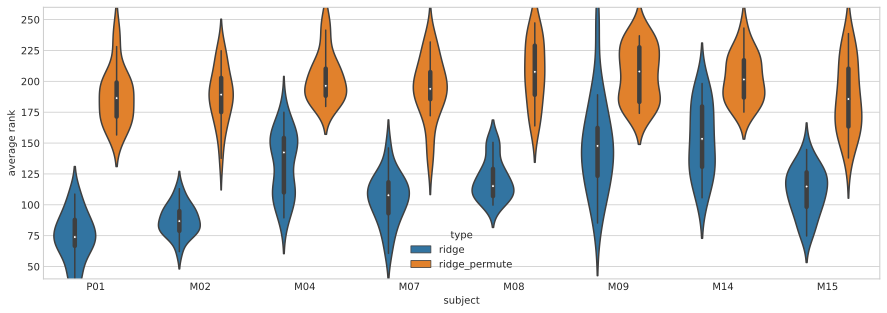

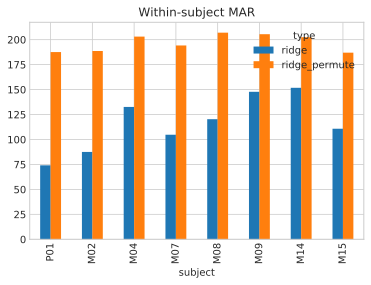

In [93]:
stats["infersent"] = analyze_encoding("infersent", "perf.384sentences.infersent.allnli.dim256.csv")
stats["infersent"]

-------------

type,ridge,ridge_permute
subject,,
P01,187.798942,193.449735
M02,189.240741,191.568783
M04,187.984127,186.753968
M07,193.441799,193.248677
M08,183.746032,178.119048
M09,196.571429,192.571429
M14,187.402116,196.555556
M15,187.417989,191.851852


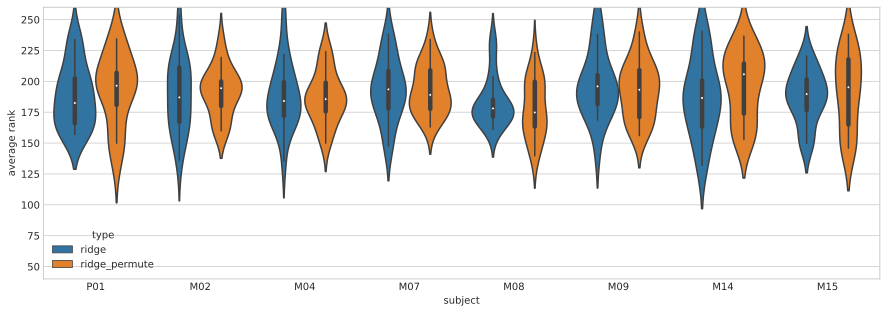

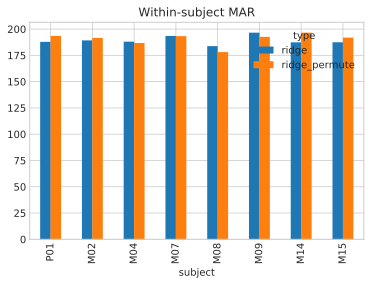

In [94]:
stats["imdb"] = analyze_encoding("imdb", "perf.384sentences.imdbsentiment.dim128.csv")
stats["imdb"]

---------

type,ridge,ridge_permute
subject,,
P01,60.423280,177.859788
M02,88.576720,179.597884
M04,127.947090,192.351852
M07,90.571429,193.357143
M08,116.769841,192.317460
M09,142.050265,192.238095
M14,153.047619,201.224868
M15,112.505291,193.055556


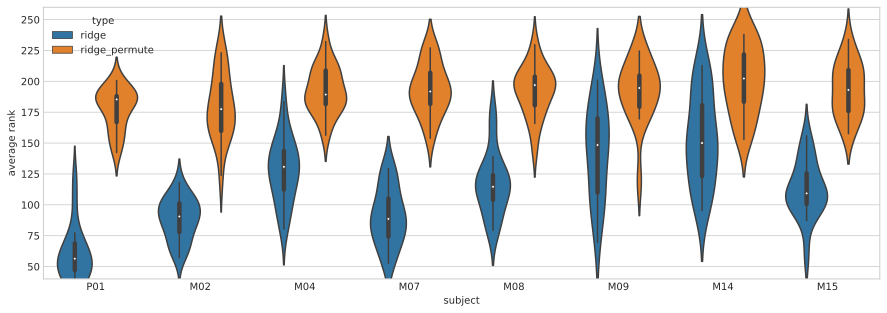

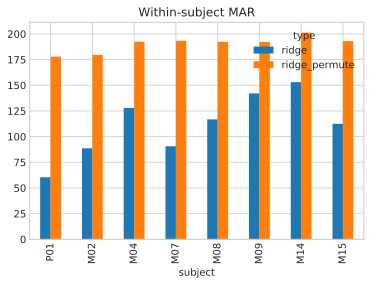

In [95]:
stats["skipthought"] = analyze_encoding("skipthought", "perf.384sentences.skipthought.dim256.csv")
stats["skipthought"]

---------

type,ridge,ridge_permute
subject,,
P01,67.775132,190.264550
M02,87.417989,189.682540
M04,143.584656,194.883598
M07,107.637566,182.269841
M08,124.148148,195.378307
M09,148.542328,206.248677
M14,154.634921,198.632275
M15,109.589947,189.997354


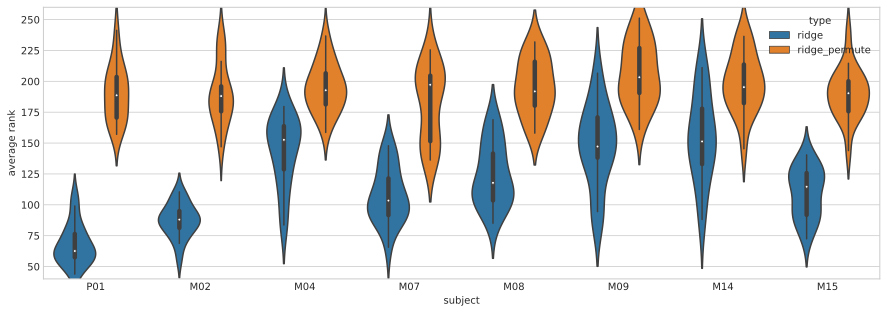

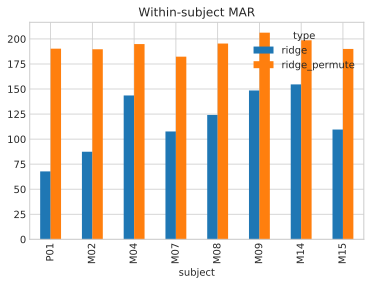

In [96]:
stats["dissent"] = analyze_encoding("dissent", "perf.384sentences.dissent.books8.epoch9.dim256.csv")
stats["dissent"]

---------

type,ridge,ridge_permute
subject,,
P01,132.129630,192.097884
M02,141.838624,199.828042
M04,165.328042,195.708995
M07,158.193122,199.574074
M08,149.222222,196.748677
M09,184.523810,198.552910
M14,179.240741,198.473545
M15,162.783069,195.650794


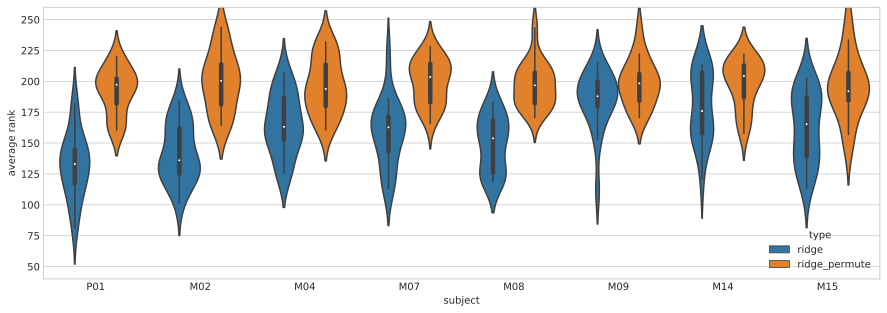

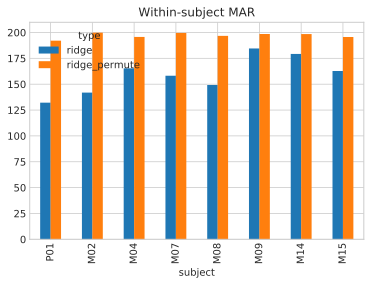

In [97]:
stats["order"] = analyze_encoding("order", "perf.384sentences.order-embeddings.csv")
stats["order"]

---------

Index(['pereira', 'skipthought', 'infersent', 'dissent', 'fairseq', 'order',
       'imdb'],
      dtype='object', name='target') Index(['dissent', 'fairseq', 'imdb', 'infersent', 'order', 'pereira',
       'skipthought'],
      dtype='object', name='target')
[-0.4  0.6  1.6  2.6  3.6  4.6  5.6  0. ]


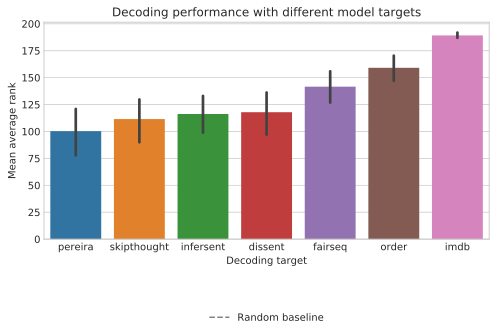

In [119]:
fig, ax = plt.subplots(figsize=(8,4))
f = pd.concat(stats, names=["target", "subject"]).reset_index()
target_order = f.groupby("target").ridge.agg("mean").argsort()
sns.barplot(x="target", y="ridge", order=target_order.index[target_order], data=f)
plt.xlabel("Decoding target")
plt.ylabel("Mean average rank")
plt.title("Decoding performance with different model targets")

import matplotlib
bars = [child for child in ax.get_children() if isinstance(child, matplotlib.patches.Rectangle)]
baselines_start = np.array([plt.getp(item, "x") for item in bars])
baselines_end = baselines_start + np.array([plt.getp(item, "width") for item in bars])
print(baselines_start)
plt.hlines(random_means, baselines_start[:-1], baselines_end[:-1], colors="gray", linestyles="dashed", label="Random baseline")

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3))